Some codes like model definition, data cleaning, and train-test splitting is repeated across the different models. I intentionally included it separately within each model so that every model would be self-contained and runnable independently, without relying on other models.



###Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import re
import numpy as np
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

###Load the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
filepath = '/content/gdrive/MyDrive/emotional_quotes_categorized.xlsx'
data = pd.read_excel(filepath)

In [5]:

print(data.shape)

(895, 3)


In [6]:
data

,Quote,Category,Category_number
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1
...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2


In [7]:

df=data
df = df.rename(columns={
    df.columns[0]: 'Title',
    df.columns[1]: 'CategoryHebrew',
    df.columns[2]: 'Label'
})

In [8]:
df

,Title,CategoryHebrew,Label
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1
...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2


###Distribution

'Label Distribution Table'

,Count,count
0,0,289
1,1,298
2,2,308


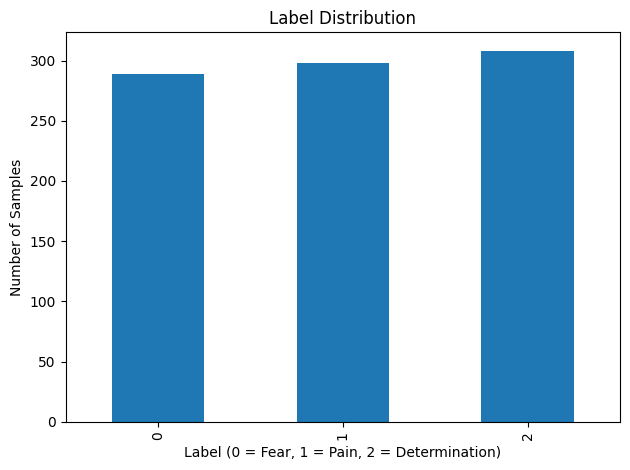

In [8]:
# Compute label distribution
label_counts = df['Label'].value_counts().sort_index()
# Display distribution table
display(
    'Label Distribution Table',
    label_counts.reset_index().rename(columns={'index': 'Label', 'Label': 'Count'})
)

# Plot distribution in English
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label (0 = Fear, 1 = Pain, 2 = Determination)')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

###HBert embedding

In [9]:
tokenizer = AutoTokenizer.from_pretrained("avichr/HeBERT")
heb_model = AutoModel.from_pretrained("avichr/HeBERT")

def get_hebert_embeddings(texts, max_length=128):
    # texts: list of strings

    # Tokenize the input texts with padding and truncation
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Disable gradient tracking for inference
    with torch.no_grad():
        out = heb_model(**enc)

    # Return the CLS token embedding (first position of each sequence)
    return out.last_hidden_state[:, 0, :]  # shape (batch_size, hidden_dim)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at avichr/HeBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import torch

# 1. Select a few of your actual examples
samples = df['Title'].iloc[:5].tolist()

# 2. Compute embeddings
embs = get_hebert_embeddings(samples, max_length=64)

# 3. Inspect shape and values
print("Embeddings shape:", embs.shape)  # Expect (5, hidden_dim)
for i, txt in enumerate(samples):
    print(f"\nSample {i}:", txt)
    print("First 5 dims:", embs[i][:5].tolist())

# 4. Check similarity for two identical inputs
identical = [samples[0], samples[0]]
emb_same = get_hebert_embeddings(identical, max_length=64)
sim_same = torch.nn.functional.cosine_similarity(
    emb_same[0].unsqueeze(0),
    emb_same[1].unsqueeze(0),
    dim=1
)
print(f"\nCosine similarity (identical inputs): {sim_same.item():.4f}")

# 5. Check similarity between sample 0 and 1
sim01 = torch.nn.functional.cosine_similarity(
    embs[0].unsqueeze(0),
    embs[4].unsqueeze(0),
    dim=1
)
print(f"Cosine similarity (sample 0 vs 3): {sim01.item():.4f}")

Embeddings shape: torch.Size([5, 768])

Sample 0: זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘אין שמאל ואין ימין — אנחנו כולנו אחים, די ! תתאחדו!’
First 5 dims: [0.2009258270263672, -0.02744739130139351, -0.06080431491136551, -0.8982285857200623, 0.7796890139579773]

Sample 1: לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’ בזמן שחיילים נהרגים, חטופים נשכחים...
First 5 dims: [0.257294625043869, 0.0651598647236824, 0.10685759782791138, -0.2148418128490448, 0.6628166437149048]

Sample 2: במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך בלחימה עד ניצחון מוחלט...
First 5 dims: [0.575165867805481, -0.1097702905535698, -0.3950302004814148, -0.3073519766330719, 0.5096400380134583]

Sample 3: סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפחה מבקשים להתפלל לשלומו...
First 5 dims: [-0.4409346282482147, 0.2775568962097168, -0.022534295916557312, -0.18043681979179382, 0.4954276382923126]

Sample 4: הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפעם לא חטופים’
First 5 dims: [1.0876926183700562, 0.802089

In [18]:
import random

# Assume 'embs' is a tensor of shape (N, D) with sentence embeddings
embs = get_hebert_embeddings(df['Title'].tolist(), max_length=64)

# Compute cosine similarity between M random pairs of embeddings
def random_pair_sims(embs, M=100):
    sims = []
    N = embs.size(0)
    for _ in range(M):
        i, j = random.sample(range(N), 2)
        sim = torch.nn.functional.cosine_similarity(
            embs[i].unsqueeze(0),
            embs[j].unsqueeze(0),
            dim=1
        ).item()
        sims.append(sim)
    return sims

sims = random_pair_sims(embs, M=200)

# Print summary statistics of similarity values
print("Min sim:", min(sims))
print("Max sim:", max(sims))
print("Mean sim:", sum(sims)/len(sims))


Min sim: 0.6749734282493591
Max sim: 0.923673152923584
Mean sim: 0.7848407498002052


###MLP

In [10]:
def minimal_clean(text):
    text = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', text).strip()

df['CleanTitle'] = df['Title'].apply(minimal_clean)
df

,Title,CategoryHebrew,Label,CleanTitle
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...
...,...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי..."
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי..."
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""..."


In [11]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'],
    test_size=0.25, random_state=42, stratify=df['Label']
)

In [12]:
import torch
texts_train = X_train.tolist()
texts_test  = X_test.tolist()

# Compute embeddings using PyTorch and convert them to NumPy arrays
with torch.no_grad():
    train_embs = get_hebert_embeddings(texts_train).cpu().numpy()
    test_embs  = get_hebert_embeddings(texts_test).cpu().numpy()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [22]:
import tensorflow as tf

input_dim = train_embs.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,635 (772.01 KB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

very high overfitting

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_embs, y_train.values,
                    validation_data=(test_embs, y_test.values),
                    epochs=10, batch_size=16)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5398 - loss: 1.0867 - val_accuracy: 0.6872 - val_loss: 0.7884
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7802 - loss: 0.5530 - val_accuracy: 0.6592 - val_loss: 0.7866
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8054 - loss: 0.5369 - val_accuracy: 0.7095 - val_loss: 0.7974
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8419 - loss: 0.4253 - val_accuracy: 0.6927 - val_loss: 0.8217
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8547 - loss: 0.3625 - val_accuracy: 0.6648 - val_loss: 0.8305
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8867 - loss: 0.3512 - val_accuracy: 0.6760 - val_loss: 0.8519
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9125 - loss: 0.2560 - val_accuracy: 0.6760 - val_loss: 0.8428
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9461 - loss: 0.2155 - val_accuracy: 0.6983 - val_lo

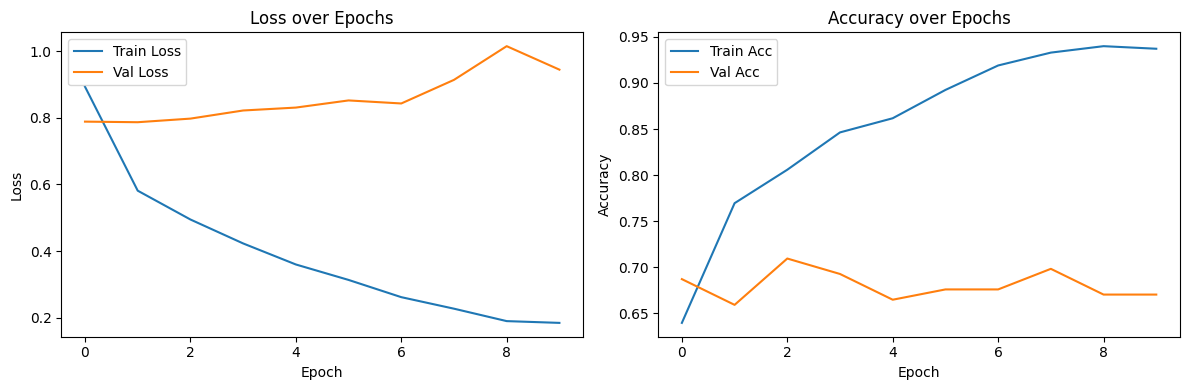

In [24]:
# Cell 5: Plot history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2976 - loss: 1.6563 - val_accuracy: 0.4330 - val_loss: 1.0626
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3724 - loss: 1.4647 - val_accuracy: 0.5179 - val_loss: 1.0051
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4141 - loss: 1.2450 - val_accuracy: 0.5848 - val_loss: 0.9546
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4584 - loss: 1.2102 - val_accuracy: 0.6116 - val_loss: 0.9061
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4839 - loss: 1.0854 - val_accuracy: 0.6339 - val_loss: 0.8615
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5535 - loss: 1.0564 - val_accuracy: 0.6295 - val_loss: 0.8270
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5621 - loss: 1.0959 - val_accuracy: 0.6429 - val_loss: 0.8054
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6092 - loss: 0.8837 - val_accuracy: 0.6429 - val_loss:

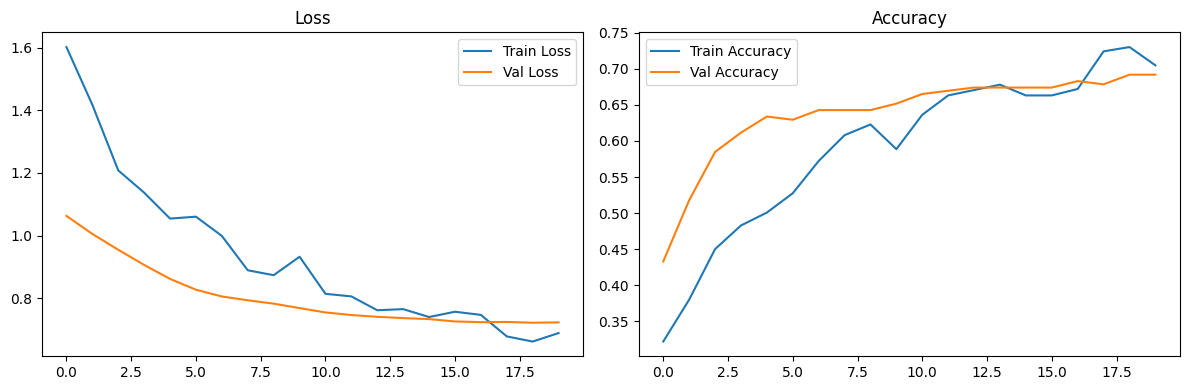

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

input_dim = train_embs.shape[1]

model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_embs, y_train.values,
    validation_data=(test_embs, y_test.values),
    epochs=20, batch_size=16,
    callbacks=[early_stop]
)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()


A little better, added regularization and less נוירונים

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,819 (386.01 KB)

 Trainable params: 98,819 (386.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5203 - loss: 3.2046 - val_accuracy: 0.6592 - val_loss: 2.3935
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7404 - loss: 2.1219 - val_accuracy: 0.6648 - val_loss: 1.9728
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7811 - loss: 1.6654 - val_accuracy: 0.6648 - val_loss: 1.7570
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7997 - loss: 1.4509 - val_accuracy: 0.6927 - val_loss: 1.5826
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7843 - loss: 1.2682 - val_accuracy: 0.6983 - val_loss: 1.4578
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7754 - loss: 1.1719 - val_accuracy: 0.6872 - val_loss: 1.3489
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8320 - loss: 1.0167 - val_accuracy: 0.7095 - val_loss: 1.3041
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8446 - loss: 0.9155 - val_accuracy: 0.6927 - va

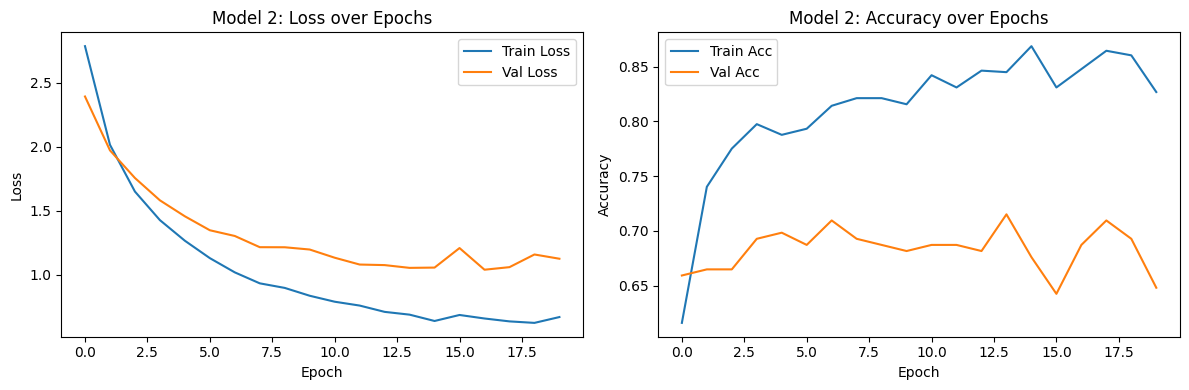

Model 2 Final Test Accuracy: 68.72%


In [25]:
# Build Model 2 with reduced complexity & stronger regularization 128 נוירונים
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(
        128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        3, activation='softmax',
        kernel_regularizer=regularizers.l2(0.01)
    )
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

# EarlyStopping callback to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train Model 2
history2 = model2.fit(
    train_embs, y_train.values,
    validation_data=(test_embs, y_test.values),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)

# Plot training & validation curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model 2: Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title('Model 2: Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
test_loss2, test_acc2 = model2.evaluate(test_embs, y_test.values, verbose=0)
print(f"Model 2 Final Test Accuracy: {test_acc2:.2%}")

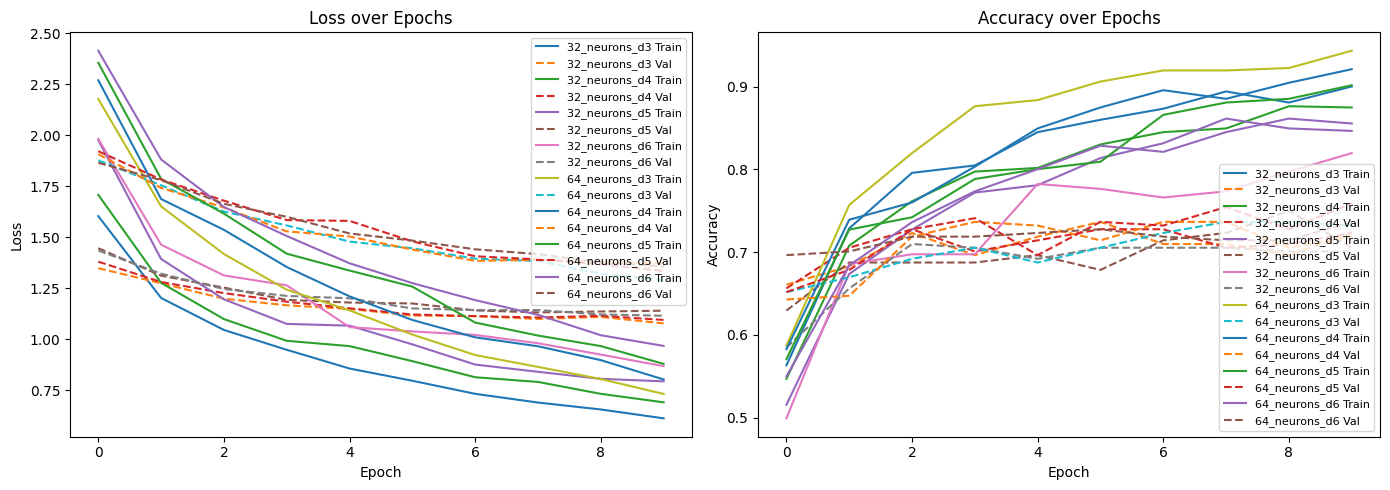

🔎 Final comparison across model configurations:


,Model,Train Acc,Val Acc,Train Loss,Val Loss
6,64_neurons_d5,0.901639,0.758929,0.878148,1.333835
7,64_neurons_d6,0.855440,0.736607,0.966364,1.355955
4,64_neurons_d3,0.943368,0.732143,0.730741,1.287826
0,32_neurons_d3,0.900149,0.723214,0.610985,1.076771
1,32_neurons_d4,0.874814,0.723214,0.689571,1.093836
5,64_neurons_d4,0.921013,0.718750,0.801677,1.370997
2,32_neurons_d5,0.846498,0.705357,0.792463,1.139172
3,32_neurons_d6,0.819672,0.700893,0.867057,1.114319


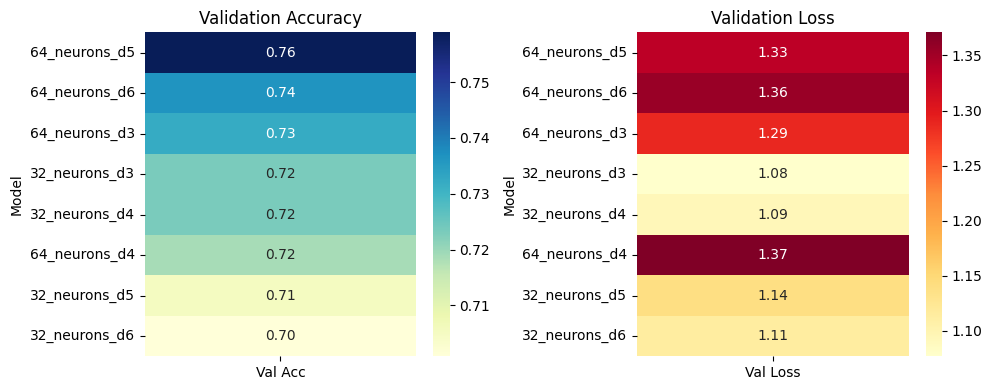

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assumes: train_embs, test_embs, y_train, y_test are already defined

neurons_list = [32, 64]
dropouts_list = [0.3, 0.4, 0.5, 0.6]
results = {}
summary_data = []

for n in neurons_list:
    for d in dropouts_list:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(train_embs.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(n, activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(d),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train_embs, y_train,
                            validation_data=(test_embs, y_test),
                            epochs=10, batch_size=16, verbose=0)

        label = f"{n}_neurons_d{int(d*10)}"
        results[label] = history.history

        # Save final values to comparison table
        summary_data.append({
            "Model": label,
            "Train Acc": history.history["accuracy"][-1],
            "Val Acc": history.history["val_accuracy"][-1],
            "Train Loss": history.history["loss"][-1],
            "Val Loss": history.history["val_loss"][-1]
        })

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, hist in results.items():
    axes[0].plot(hist['loss'], label=f"{label} Train")
    axes[0].plot(hist['val_loss'], linestyle='--', label=f"{label} Val")
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(fontsize=8)

for label, hist in results.items():
    axes[1].plot(hist['accuracy'], label=f"{label} Train")
    axes[1].plot(hist['val_accuracy'], linestyle='--', label=f"{label} Val")
axes[1].set_title("Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Create and display comparison table
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(by="Val Acc", ascending=False)
import seaborn as sns

print("🔎 Final comparison across model configurations:")
display(df_summary)

plt.figure(figsize=(10, 4))

# Heatmap for Val Accuracy
plt.subplot(1, 2, 1)
sns.heatmap(df_summary.set_index("Model")[["Val Acc"]], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Validation Accuracy")

# Heatmap for Val Loss
plt.subplot(1, 2, 2)
sns.heatmap(df_summary.set_index("Model")[["Val Loss"]], annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Validation Loss")

plt.tight_layout()
plt.show()


###RNN

In [8]:
#  Minimal cleaning: lowercase and remove URLs
def minimal_clean(text):
    t = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', t).strip()

df['CleanTitle'] = df['Title'].apply(minimal_clean)

#  Split to train & test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'],
    test_size=0.2, random_state=42, stratify=df['Label'],
)

In [9]:
#  Load & Freeze HeBERT
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("avichr/HeBERT")
tf_model = TFAutoModel.from_pretrained("avichr/HeBERT", from_pt=True)
tf_model.trainable = False  # freeze transformer weights

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model)

In [10]:
#  Prepare tf.data.Dataset
import tensorflow as tf

max_length = 128
batch_size = 16

def encode(texts):
    """Tokenize and encode a list of texts for the transformer."""
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

def make_dataset(texts, labels):
    """Build a tf.data.Dataset of (inputs_dict, label)."""
    enc = encode(texts.tolist())
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, Lambda

# Inputs for token IDs and attention mask
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Lambda layer to extract sequence embeddings from frozen transformer
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    # tf_model returns (last_hidden_state, pooler_output, ...)
    return tf_model(ids, attention_mask=mask)[0]

seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    918,528 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │     16,448 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 935,683 (3.57 MB)

 Trainable params: 935,683 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.4915 - loss: 1.1931 - val_accuracy: 0.6425 - val_loss: 0.8543
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.7492 - loss: 0.6275 - val_accuracy: 0.6648 - val_loss: 0.7624
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 269s 6s/step - accuracy: 0.7916 - loss: 0.5404 - val_accuracy: 0.6369 - val_loss: 0.8708
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.8206 - loss: 0.4261 - val_accuracy: 0.6257 - val_loss: 1.0358


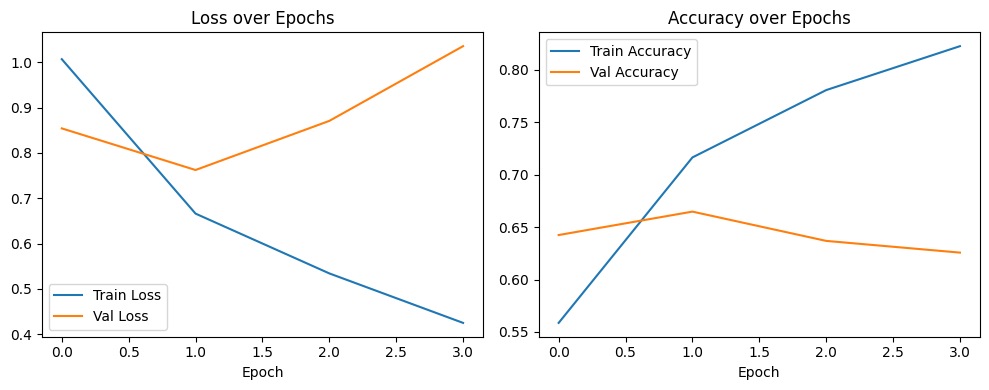

In [18]:
# Define RNN Model (Bi-LSTM) on Top of Frozen Transformer Embeddings

# BiLSTM + normalization + dense head
x = Bidirectional(LSTM(128))(seq_output)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)

rnn_model = Model(inputs=[inp_ids, inp_mask], outputs=out)
rnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
rnn_model.summary()

#  Train
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)

history = rnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)

#  Plot Training Results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    426,496 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 3)         │        195 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,203 (1.66 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.3376 - loss: 1.5663 - val_accuracy: 0.4413 - val_loss: 1.0853
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 292s 7s/step - accuracy: 0.4579 - loss: 1.1270 - val_accuracy: 0.5196 - val_loss: 1.0008
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.5674 - loss: 0.9116 - val_accuracy: 0.5587 - val_loss: 0.9528
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 300s 7s/step - accuracy: 0.6624 - loss: 0.7978 - val_accuracy: 0.5810 - val_loss: 0.9251
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - accuracy: 0.6679 - loss: 0.7333 - val_accuracy: 0.5978 - val_loss: 0.8984
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 267s 6s/step - accuracy: 0.7236 - loss: 0.6581 - val_accuracy: 0.6034 - val_loss: 0.8825
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 294s 7s/step - accuracy: 0.7260 - loss: 0.6827 - val_accuracy: 0.6089 - val_loss: 0.8751
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.7388 - loss: 0.6048 - val_accuracy: 0.6201 - v

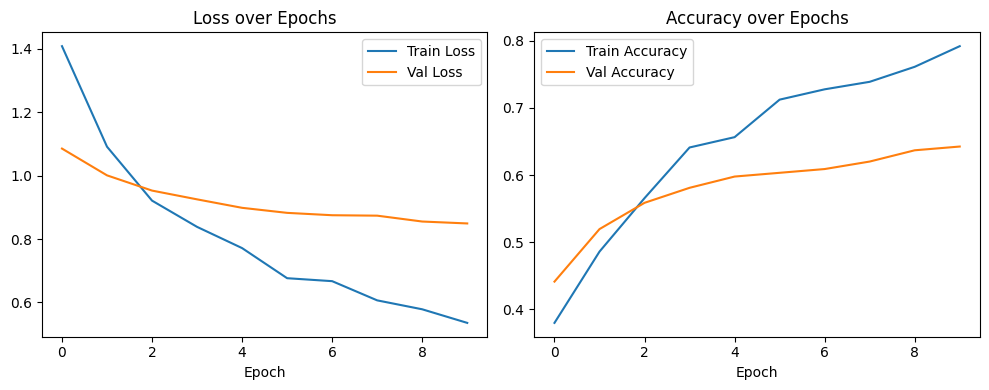

In [19]:
x = Bidirectional(LSTM(64))(seq_output)
x = LayerNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)  # stronger regularization
out = Dense(3, activation="softmax")(x)

rnn_model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile with low learning rate + label smoothing
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


rnn_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
rnn_model.summary()

#  Train the model
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = rnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


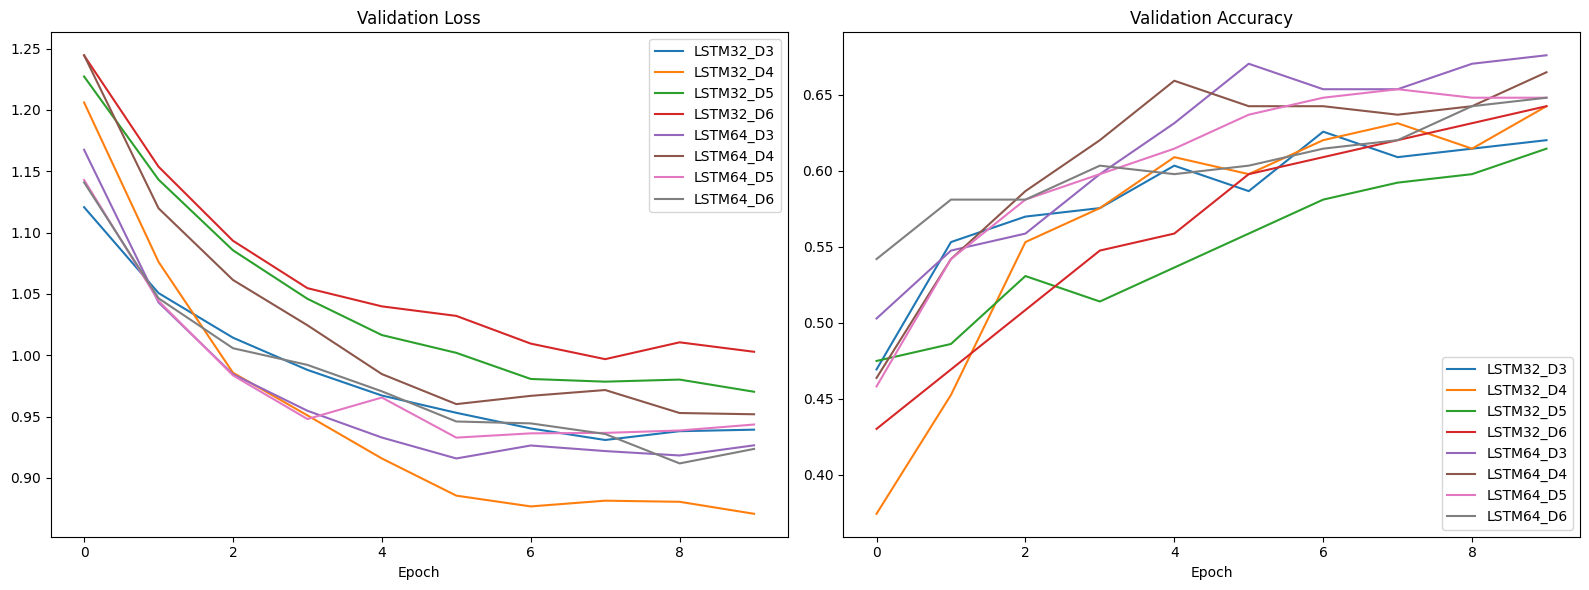

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Dictionary to store training history for each configuration
results = {}

# Iterate over combinations of LSTM units and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        # Define model architecture using BiLSTM and regularized dense layers
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Train the model silently (verbose=0)
        history = model.fit(train_ds,
                            validation_data=test_ds,
                            epochs=10,
                            batch_size=16,
                            verbose=0)

        # Store training history
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history

# Plot validation loss and accuracy for each configuration
plt.figure(figsize=(16,6))

# Validation Loss
plt.subplot(1,2,1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=f"{label}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=f"{label}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    rows.append((name, best_acc, best_loss))

df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
4,LSTM64_D3,0.675978,0.915808
5,LSTM64_D4,0.664804,0.951845
6,LSTM64_D5,0.653631,0.932805
7,LSTM64_D6,0.648045,0.911774
3,LSTM32_D6,0.642458,0.996788
1,LSTM32_D4,0.642458,0.870693
0,LSTM32_D3,0.625698,0.930874
2,LSTM32_D5,0.614525,0.970206


###  partial fine- tuning

In [26]:
# Load AlephBERT and enable fine-tuning for last 3 layers
from transformers import AutoTokenizer, TFAutoModel

#: Load and freeze everything

model_name = "avichr/HeBERT"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tf_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
tf_model.trainable = False  # Freeze entire model

#  Fine-tune only last 3 layers
for layer in tf_model.bert.encoder.layer[-3:]:
    layer.trainable = True


for i, layer in enumerate(tf_model.bert.encoder.layer):
    print(f"Layer {i} trainable: {layer.trainable}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Layer 0 trainable: False
Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: True
Layer 10 trainable: True
Layer 11 trainable: True


In [27]:
def minimal_clean(text):
    # Convert text to lowercase and remove URLs
    text = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', text).strip()

# Apply minimal cleaning to the 'Title' column
df['CleanTitle'] = df['Title'].apply(minimal_clean)

# Split the data into training and test sets (stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'],
    test_size=0.25, random_state=42, stratify=df['Label']
)

# Parameters for tokenization and batching
max_length = 128
batch_size = 16

# Tokenize and encode texts using the transformer tokenizer
def encode(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Build a tf.data.Dataset from encoded input and labels
def make_dataset(texts, labels):
    enc = encode(texts.tolist())
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare train and test datasets
train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)


In [28]:
# Define the model architecture using a BiLSTM on top of frozen transformer outputs

import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Lambda, Bidirectional, LSTM, Dense, Dropout, LayerNormalization

# Define input layers for the transformer model
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract the last hidden states (sequence output) from the transformer
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    return tf_model(ids, attention_mask=mask)[0]

# Wrap transformer output in a Lambda layer
seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])

# Classification head: BiLSTM + normalization + dense layers
x = Bidirectional(LSTM(64))(seq_output)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)

# Final model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)


In [29]:
# Compile with low LR for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 128)       │    426,496 │ lambda_10[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_18… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64)        │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 3)         │        195 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,203 (1.66 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#  Train
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.3590 - loss: 2.5532 - val_accuracy: 0.3571 - val_loss: 2.0621
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.3941 - loss: 2.1998 - val_accuracy: 0.4688 - val_loss: 1.9293
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.4443 - loss: 2.1056 - val_accuracy: 0.5179 - val_loss: 1.8555
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.5156 - loss: 1.9813 - val_accuracy: 0.5670 - val_loss: 1.8039
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.5356 - loss: 1.8861 - val_accuracy: 0.5938 - val_loss: 1.7679
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.5485 - loss: 1.8133 - val_accuracy: 0.6205 - val_loss: 1.7360
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.5631 - loss: 1.8401 - val_accuracy: 0.6027 - val_loss: 1.7121
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.5889 - loss: 1.7435 - val_accuracy:

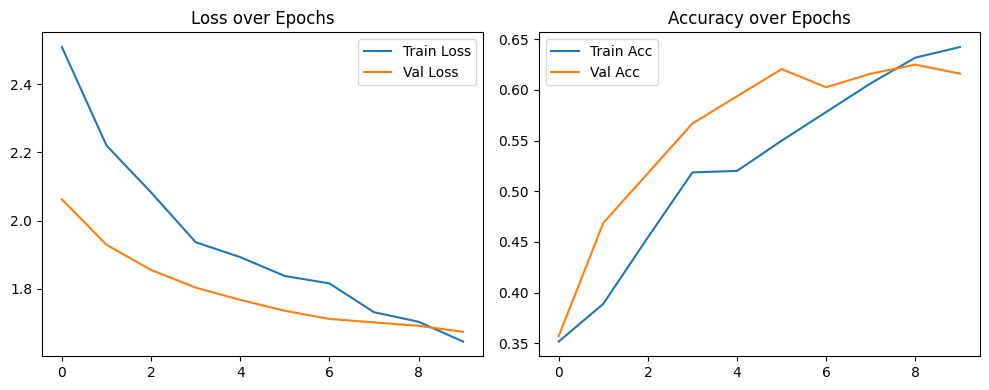

In [31]:
# Evaluate
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs"); plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 389ms/step - accuracy: 0.4069 - loss: 1.6344 - val_accuracy: 0.4018 - val_loss: 1.3161 - learning_rate: 3.0000e-05
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.4227 - loss: 1.5056 - val_accuracy: 0.4062 - val_loss: 1.2387 - learning_rate: 3.0000e-05
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.3928 - loss: 1.4854 - val_accuracy: 0.4420 - val_loss: 1.2044 - learning_rate: 3.0000e-05
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.4285 - loss: 1.3627 - val_accuracy: 0.4509 - val_loss: 1.1797 - learning_rate: 3.0000e-05
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.4181 - loss: 1.2982 - val_accuracy: 0.4554 - val_loss: 1.1580 - learning_rate: 3.0000e-05
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.4524 - loss: 1.2349 - val_accuracy: 0.4643 - val_loss: 1.1415 - learning_rate: 3.0000e-05
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accurac

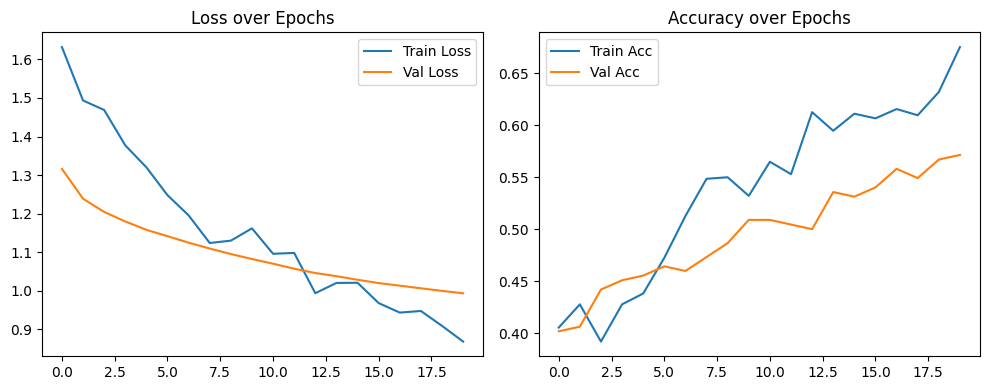

In [32]:
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, GlobalMaxPooling1D, LayerNormalization

# Define model inputs
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract the last hidden state (sequence output) from the transformer
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    return tf_model(ids, attention_mask=mask)[0]

# Wrap transformer output in Lambda layer
seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])

# Apply global max pooling and dense layers for classification
x = GlobalMaxPooling1D()(seq_output)
x = LayerNormalization()(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
out = Dense(3, activation="softmax")(x)

# Build the model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile with low learning rate and sparse categorical loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Learning rate scheduling and early stopping callbacks
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop, lr_schedule]
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs"); plt.legend()

plt.tight_layout()
plt.show()


Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


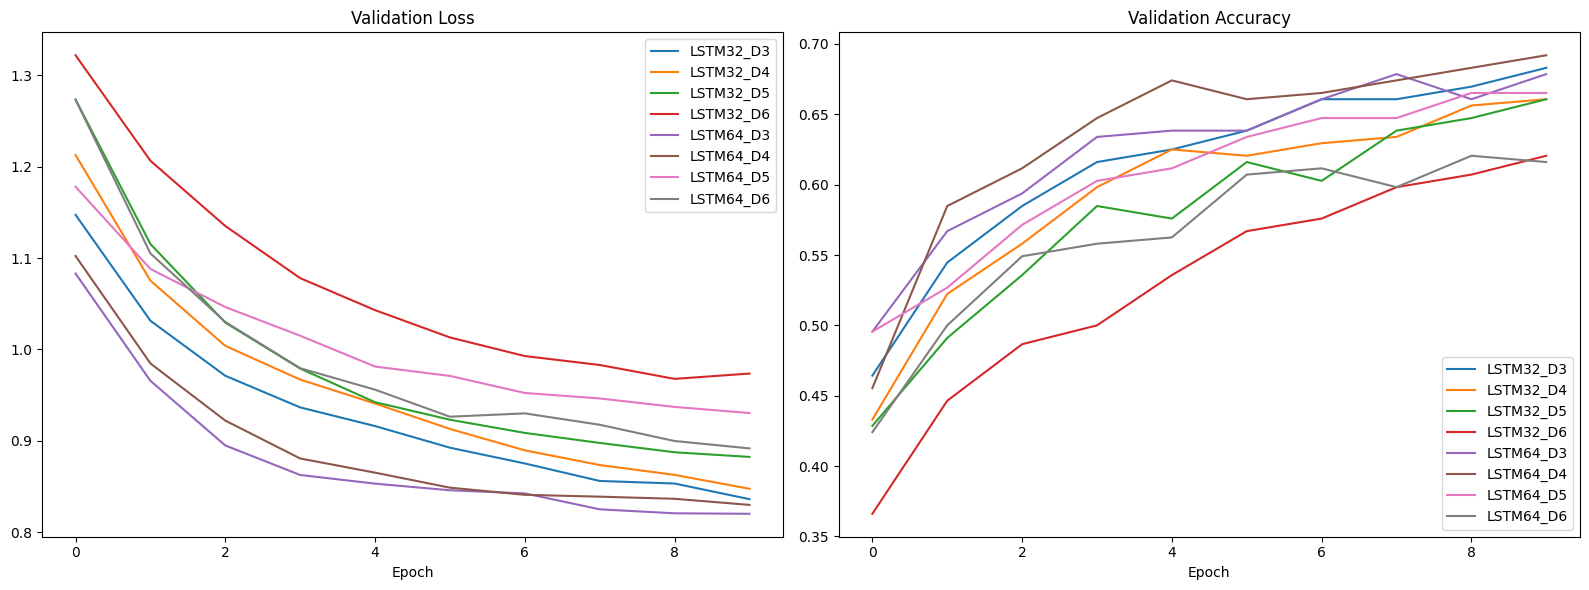

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Dictionary to store training history for each configuration
results = {}

# Iterate over different LSTM unit sizes and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        # Build model architecture
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Train the model silently
        history = model.fit(train_ds,
                            validation_data=test_ds,
                            epochs=10,
                            batch_size=16,
                            verbose=0)

        # Store training history
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history

# Plot validation loss and accuracy for all models
plt.figure(figsize=(16,6))

# Validation Loss
plt.subplot(1,2,1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=f"{label}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=f"{label}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    rows.append((name, best_acc, best_loss))

df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
5,LSTM64_D4,0.691964,0.829878
0,LSTM32_D3,0.683036,0.836140
4,LSTM64_D3,0.678571,0.820138
6,LSTM64_D5,0.665179,0.930367
1,LSTM32_D4,0.660714,0.847512
2,LSTM32_D5,0.660714,0.882374
3,LSTM32_D6,0.620536,0.967760
7,LSTM64_D6,0.620536,0.891695


### Full fine- tuning

In [13]:
from transformers import AutoTokenizer, TFAutoModel

model_name = "avichr/HeBERT"

# Load the pretrained tokenizer for HeBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pretrained HeBERT model (converting from PyTorch weights)
bert = TFAutoModel.from_pretrained(model_name, from_pt=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

In [14]:

bert.summary()

for i, layer in enumerate(bert.bert.encoder.layer):
    print(f"Transformer Layer {i} - trainable: {layer.trainable}")


Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Transformer Layer 0 - trainable: True
Transformer Layer 1 - trainable: True
Transformer Layer 2 - trainable: True
Transformer Layer 3 - trainable: True
Transformer Layer 4 - trainable: True
Transformer Layer 5 - trainable: True
Transformer Layer 6 - trainable: True
Transformer Layer 7 - trainable: True
Transformer Layer 8 - trainable: True
Transformer Layer 9 - trainable: True
Transformer Layer 10 - trainable: True
Transformer Layer 11 - trainable: True


In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda

max_length = 128
batch_size = 16

# Split the data into train and test sets with stratified label distribution
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'].astype(int), test_size=0.2, stratify=df['Label'], random_state=42
)

# Tokenize and encode input texts
def encode(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Create a tf.data.Dataset from encoded inputs and labels
def make_dataset(texts, labels):
    enc = encode(texts)
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare training and test datasets
train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)

# Define model input layers
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract the CLS token representation (first token) from transformer output
def extract_CLS(inputs):
    ids, mask = inputs
    output = bert(ids, attention_mask=mask)[0]  # shape: (batch, seq_len, hidden_dim)
    return output[:, 0, :]  # return CLS token only

cls_embedding = Lambda(
    extract_CLS,
    output_shape=(bert.config.hidden_size,)
)([inp_ids, inp_mask])


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - accuracy: 0.3521 - loss: 1.4293 - val_accuracy: 0.4972 - val_loss: 1.1900
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.3903 - loss: 1.3337 - val_accuracy: 0.5028 - val_loss: 1.1304
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4473 - loss: 1.2219 - val_accuracy: 0.5531 - val_loss: 1.0870
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4987 - loss: 1.1361 - val_accuracy: 0.5698 - val_loss: 1.0556
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5387 - loss: 1.0510 - val_accuracy: 0.5978 - val_loss: 1.0310
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5899 - loss: 0.9900 - val_accuracy: 0.5978 - val_loss: 1.0094
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6112 - loss: 0.9777 - val_accuracy: 0.6257 - val_loss: 0.9897
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6010 - loss: 0.9767 - val_accuracy:

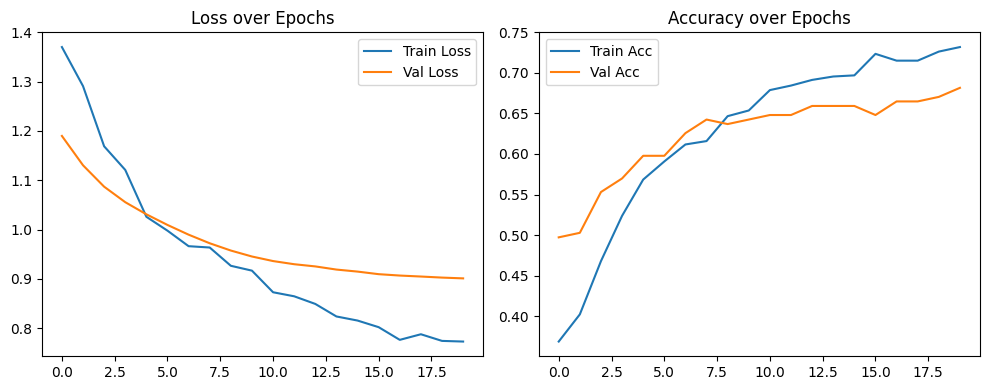

In [16]:
# Classification head on top of the CLS embedding
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(cls_embedding)
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)

# Build the model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile the model with Adam optimizer and sparse categorical loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[es])

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs"); plt.legend()

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:


,precision,recall,f1-score,support
0,0.710526,0.465517,0.562500,58.000000
1,0.680556,0.816667,0.742424,60.000000
2,0.666667,0.754098,0.707692,61.000000
accuracy,0.681564,0.681564,0.681564,0.681564
macro avg,0.685916,0.678761,0.670872,179.000000
weighted avg,0.685534,0.681564,0.672289,179.000000


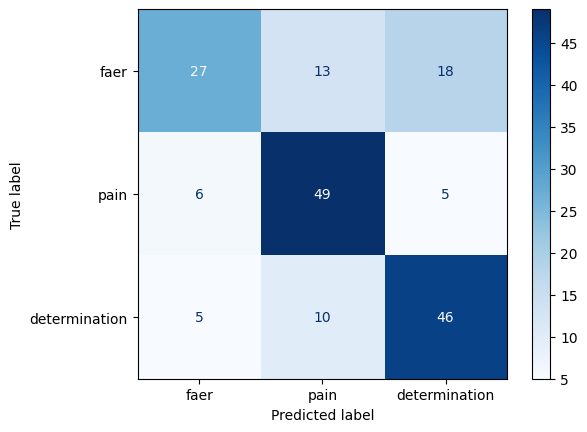

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Encode test texts into input_ids and attention_mask
encoded = tokenizer(
    X_test.tolist(),  # list of texts
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Step 2: Predict emotion class probabilities
pred_probs = model.predict({
    "input_ids": encoded["input_ids"],
    "attention_mask": encoded["attention_mask"]
})

# Convert predicted probabilities to class labels
y_pred = np.argmax(pred_probs, axis=1)

# Step 3: Prepare true labels
y_true = y_test.astype(int)  # Alternatively: df['Label'].iloc[test_idx]

# Step 4: Generate and display classification report
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print("Classification Report:")
display(df_report)

# Step 5: Plot confusion matrix
labels = ['faer', 'pain', 'determination']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


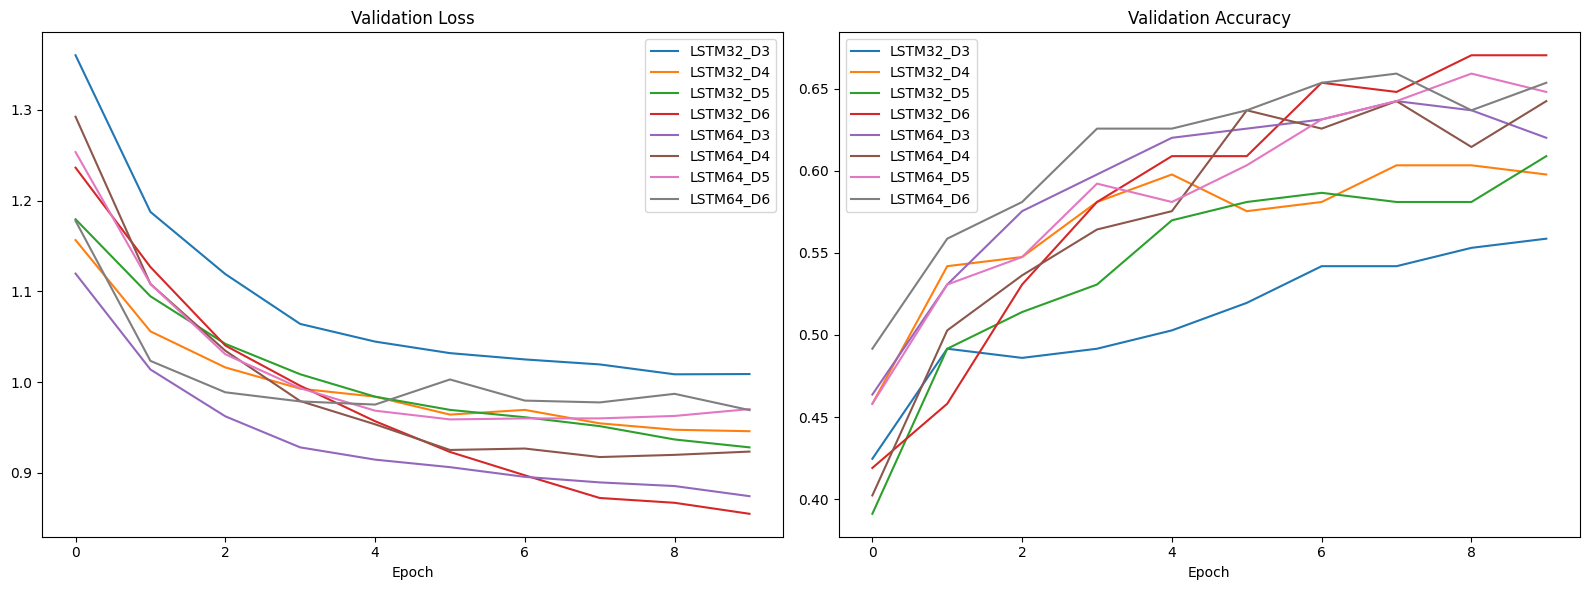

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Dictionary to store training history for each (LSTM units, dropout) configuration
results = {}

# Iterate over combinations of LSTM sizes and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
        inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

        # Assume tf_model (e.g., HeBERT) is already loaded
        def extract_sequence_outputs(inputs):
            ids, mask = inputs
            return tf_model(ids, attention_mask=mask)[0]

        seq_output = Lambda(
            extract_sequence_outputs,
            output_shape=(max_length, tf_model.config.hidden_size)
        )([inp_ids, inp_mask])

        # Model architecture: BiLSTM + dense + normalization + dropout
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Train the model
        history = model.fit(train_ds,
                            validation_data=test_ds,
                            epochs=10,
                            verbose=0)

        # Store training history
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history

# Plot validation loss and accuracy for all model configurations
plt.figure(figsize=(16,6))

# Validation Loss
plt.subplot(1,2,1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=f"{label}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=f"{label}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    rows.append((name, best_acc, best_loss))

df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
3,LSTM32_D6,0.670391,0.855035
7,LSTM64_D6,0.659218,0.969257
6,LSTM64_D5,0.659218,0.958995
5,LSTM64_D4,0.642458,0.917546
4,LSTM64_D3,0.642458,0.874448
2,LSTM32_D5,0.608939,0.928201
1,LSTM32_D4,0.603352,0.946001
0,LSTM32_D3,0.558659,1.008673


### In addition

In [37]:
def predict_emotion(text):
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

    # שליפת טנסורים מה-BatchEncoding לפי סדר שכבות הקלט של המודל
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # העברת הקלט כמערך טנסורים, לא כמילון
    logits = model([input_ids, attention_mask], training=False)

    pred = tf.argmax(logits, axis=1).numpy()[0]

    label_map = {0: "פחד", 1: "כאב", 2: "נחישות"}
    return label_map[pred]

# דוגמה:
print(predict_emotion("חייל נהרג מירי בכניסה לקיבוץ."))
print(predict_emotion("הכוחות ממשיכים בלחימה בנחישות."))
print(predict_emotion("אזעקה הופעלה בירושלים"))
print(predict_emotion("כוחות צהל תקפו באיראן"))
print(predict_emotion("נפילת טיל ברחובות"))

כאב
נחישות
פחד
נחישות
פחד


In [39]:
#news from today- 29/07/2025


print("ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה  ", predict_emotion("ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה  "))
print("דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן  ",predict_emotion("דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן  "))
print("אישה נפצעה קל מירי כדור תועה ברחבת הכותל  ",predict_emotion("אישה נפצעה קל מירי כדור תועה ברחבת הכותל  "))
print("חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות  ", predict_emotion("חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות  "))

ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה   נחישות
דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן   פחד
אישה נפצעה קל מירי כדור תועה ברחבת הכותל   כאב
חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות   כאב
